# Classical Shadows

The output of a quantum computer is a histogram of measurements, corresponding to the different outcomes observed, usually expressed as bitstrings. The cost and duration of a quantum experiment is roughly linear with the number of shots used to build such histograms, which also correlates with the accuracy of the results. The emergent method of classical shadows ([Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953)) have been developed to mitigate the measurement overhead by offloading quantum tasks to the pre- and post-processing steps. This prediction protocol exhibits logarithmic scaling with the number of shots to evaluate observables within a wanted accuracy.

In short, gates representing a unitary are appended to the state encoded in a quantum circuit. An experiment is carried out and the output bitstring (100101..) is stored in a conventional register. This is repeated $N$ times, where $N$ is defnied as the shadow size. Observables are computed from this representation called a "classical shadow". Different classical shadow flavours exist, as they each comes with a specific protocol for choosing a set of unitaries to append.

![Classical Shadows overview](img/classical_shadow_overview.png "Classical Shadow")
(Cite the original paper)

Users can leverage this protocol by performing the relevant pre- and post-processing functions, as introduced in this notebook. The randomized, derandomized and adaptive single-qubit Pauli basis classical shadows are currently available in Tangelo.

## System

To demonstrate the classical shadow capabilities, we first define a molecular system composed of two hydrogen atoms in the 3-21G basis. When translated to a qubit language, it  

In [1]:
from tangelo.molecule_library import mol_H2_321g
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits

# Encoding options.
encoding = "scBK"
up_then_down = True

# Converting the fermionic Hamiltonian according to the encoding options.
qubit_ham = fermion_to_qubit_mapping(mol_H2_321g.fermionic_hamiltonian, 
                                     encoding, 
                                     n_spinorbitals=mol_H2_321g.n_active_sos, 
                                     n_electrons=mol_H2_321g.n_active_electrons, 
                                     up_then_down=up_then_down)

print(f"Number of qubits to describe the system: {count_qubits(qubit_ham)}")

Number of qubits to describe the system: 6


For this example, the qubit coupled-cluster (QCC) ansatz have been chosen (Journal of Chemical Theory and Computation 2018 14 (12), 6317-6326. 10.1021/acs.jctc.8b00932). The QCC ansatz operator $\hat{U}(\tau)$ is specified according to the equation
$$
\hat{U}(\tau) = \prod_k^{n_g} \exp{-\frac{i\tau_k \hat{P}_k}{2}}
$$

While the depth of the circuit rapidly increases as the size of the molecule increases, the QCC ansatz admits a low-depth quantum circuit compared to a widely used unitary coupled-cluster single and double ansatz. 

In [2]:
from tangelo.toolboxes.ansatz_generator.qcc import QCC

ansatz = QCC(mol_H2_321g, mapping=encoding, up_then_down=up_then_down)
ansatz.build_circuit()

print(f"Number of gates in the circuit: {ansatz.circuit.size}")

Number of gates in the circuit: 79


The Variational Quantum Eigensolver (VQE) has been introduced in another notebook as a hybrid quantum–classical algorithm for simulating quantum systems. In the next cell, we focus on VQE within the context of solving the molecular electronic structure problem for the dihydrogen ground-state energy in the 3-21G basis described by the QCC ansatz.

In [3]:
from tangelo.algorithms.variational import VQESolver

vqe = VQESolver({"qubit_hamiltonian": qubit_ham, "ansatz": ansatz.circuit})
vqe.build()
energy_ref = vqe.simulate()
print(f"Energy from statevector simulation: {energy_ref:.4f} hartree")

Energy from statevector simulation: -1.1475 hartree


Now, we can refer to the optimized circuit with the `vqe.optimal_circuit` keyword and we know that with the provided Hamiltonian, the ideal energy is -1.1475 hartree. A visual representation of the circuit is shown below.

![QCC circuit for H2 in 3-21G basis](img/H2_321g_QCC.png "QCC circuit")

## Reference values

- Without Noise, tell how it should be easy to test
- Equally distributed (easiest method)
- Research is done to allocate number of measurements depending of the coefficients / variances in a qubit Hamiltonian
- We provide qubit-wise commutativity at the time of writing this notebook
- Assume number of terms is large....

Nextly, we want to acquire a reference value to evaluate the efficacy of classical shadows. One of the state-of-the-art method is the qubitwise commutativity accessible with the `group_qwc` function. It defines the minimal number of basis to measure by identifying commutating terms. Then, the number of shots can be distributed equally or according to an heuristic that considers the term coefficients.

The reference value compute in the next cell only contains statistical error and no quantum noise present in hardware. This shot-based simulation culminates with an energy containing an  error $\epsilon$, inherent to the finite numbers of measurements. This error $\epsilon$ will be compared to the ones coming from classical shadow protocols. A user who wants to compare noisy values can do it so by providing the appropriate `noise_model` to the `Simulator` defined in the few next cells. 

In [4]:
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.measurements import group_qwc, exp_value_from_measurement_bases
from tangelo.linq import Simulator, Circuit
from tangelo.linq.helpers import measurement_basis_gates

# Performing qubit-wise commutativity.
qubitwise_measurements = group_qwc(qubit_ham)

# Dividing the available number of shots equally for the amount of identified basis.
n_shots_budget = 10000
n_shots_per_basis = round(n_shots_budget / len(qubitwise_measurements))

# Shot-based backend.
backend = Simulator("cirq", n_shots=n_shots_per_basis, noise_model=None)

# Computing the histograms for the grouped basis.
qubitwise_results = dict()
for basis in qubitwise_measurements.keys():
    basis_circuit = Circuit(measurement_basis_gates(basis))
    qubitwise_results[basis], _ = backend.simulate(vqe.optimal_circuit + basis_circuit)

# Computing the energy from the histograms.
energy_shots = exp_value_from_measurement_bases(qubitwise_measurements, qubitwise_results)

print(f"Energy with qubit-wie commutativity and equally distributed shots: {energy_shots:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_shots):.3f} hartree")

Energy with qubit-wie commutativity and equally distributed shots: -1.1948 hartree
Error vs statevector simulation: 0.047 hartree


## Classical Shadows

- Talk about defining the backend (without or with noise)
- Tell about the warning if n_shots =/= 1 (explain the process behind)
- Data structure and important function in our implementation.

Firstly, we change the number of shots in the backend to 1. It is not necessary, but a warning would appear and the number will be changed automatically.

In [5]:
backend.n_shots = 1

As stated earlier, three classical shadow flavours are available in Tangelo. Each flavour has a distinct class: `RandomizedClassicalShadow`, `DerandomizedClassicalShadow` and `AdaptiveClassicalShadow`. Common methods `build` and `simulate` are defined to respectively construct the unitaries set and simulate results with a given backend.

### Randomized Single-Qubit Pauli Classical Shadows

Randomized procedure comes from the original report on classical shadows. Random basis are constructed from the tensor product of random Pauli single-qubit gates (X, Y or Z). Those samples can then be inverted with the quantum channel

$$
\mathcal{M}_p^{-1} = \bigotimes_{i=1}^n \mathcal{M}_i^{-1}
$$

Observables can then be predicted from the median of means. More details can be found in [Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953).

In [6]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
random_cs.build(n_shots_budget)
random_cs.simulate(backend)

energy_random = random_cs.get_observable(qubit_ham)
print(f"Energy from randomized single-Pauli classical shadow: {energy_random:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_random):.3f} hartree")

Energy from randomized single-Pauli classical shadow: -1.0549 hartree
Error vs statevector simulation: 0.093 hartree


### Derandomized Single-Qubit Pauli Classical Shadows

The derandomized procedure comes to fix a problem with the randomized procedure. As the number of qubits increase, the probability of hitting long Pauli words in a qubit Hamiltonian decrease greatly. Therefore, a bigger shadow are needed. The derandomized procedure uses a provided qubit operator to steer the basis choices. This results in basis that hits systematically the relevant operator. An elaboration on this algorikthm is written in [Phys. Rev. Lett. 127, 030503](https://arxiv.org/abs/2103.07510).

In [7]:
from tangelo.toolboxes.measurements import DerandomizedClassicalShadow

derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
derandom_cs.build(n_shots_budget, qubit_ham)
derandom_cs.simulate(backend)

energy_derandom = derandom_cs.get_observable(qubit_ham)
print(f"Energy from derandomized single-Pauli classical shadow: {energy_derandom:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_derandom):.3f} hartree")

Energy from derandomized single-Pauli classical shadow: -1.1585 hartree
Error vs statevector simulation: 0.011 hartree


### Adaptive Single-Qubit Pauli Classical Shadows

Another procedure for chosing basis is the adaptive procedure. It uses an iterative process to draw single-qubit Pauli gates for each qubit, one at the time. The probability distributions are built so the next single-qubit Pauli gates drawn will depend on the measurement bases already assigned to previous qubits. For more details on this algorithm, we refer to [arXiv:2105.12207](https://arxiv.org/abs/2105.12207).

In [8]:
from tangelo.toolboxes.measurements import AdaptiveClassicalShadow

adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
adaptive_cs.build(n_shots_budget, qubit_ham)
adaptive_cs.simulate(backend)

energy_adaptive = adaptive_cs.get_observable(qubit_ham)
print(f"Energy from adaptive single-Pauli classical shadow: {energy_adaptive:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_adaptive):.3f} hartree")

Energy from adaptive single-Pauli classical shadow: -1.1684 hartree
Error vs statevector simulation: 0.021 hartree


## More data...

- There are some randomness in the classical shadows protocol. Therefore, your mileage may vary.
- We have ran 10 simulations, with JW and scBK encoding (8 or 6 qubits).
- Plot of abs(e_shadow - e_statevector).
![Alt Text](img/draft_classical_shadow_flavours.png "Plot")

- Discussion about the plot: classical shadow gives a probability of computing an observable within a given accuracy vs the number fo shots.
- Talk about the noise resistance -> classical shadows is more robust.

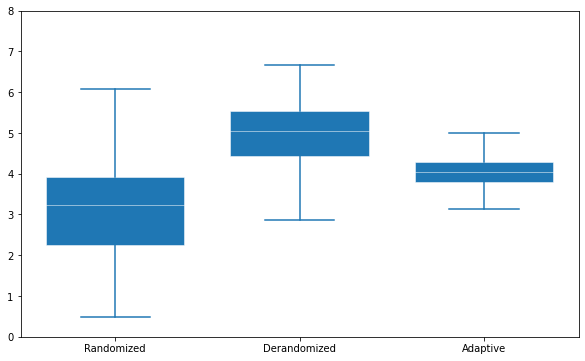

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# make data:
np.random.seed(10)
D = np.random.normal((3, 5, 4), (1.25, 1.00, 0.5), (100, 3))

# plot
fig, ax = plt.subplots(figsize=(10,6))
VP = ax.boxplot(D, positions=[2, 4, 6], labels=["Randomized", "Derandomized", "Adaptive"],
                widths=1.5, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})

ax.set(ylim=(0, 8), yticks=np.arange(0, 9))

plt.show()

## Closing words

- Closing words...
- Summarize what has been learnt
- Scaling (in what situation good or bad)